# 🎯 Análisis de Movimientos - Extracción de Características

Este notebook extrae características clave para entrenar un modelo de clasificación de movimientos:

## 📊 Características Extraídas:

### 1. **Estado Estático (Sentado/Parado)**
- Ángulo de rodilla (grados)
- Ángulo de cadera (grados)

### 2. **Transición (Sentándose/Parándose)**
- Velocidad angular de rodilla (grados/frame)
- Velocidad angular de cadera (grados/frame)

### 3. **Giro**
- Cambio de ángulo del vector de hombros en plano XZ (grados/frame)

## 📦 Instalación e Imports

In [ ]:
!pip install mediapipe opencv-python-headless matplotlib pandas scikit-learn

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.colab.patches import cv2_imshow
import os
import shutil
from typing import Dict, List, Tuple, Optional
import json

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


## 🔧 Configuración

In [ ]:
# Configuración general
VIDEO_FILE_NAME = "video.mp4"
OUTPUT_DIR = "outputs"
TARGET_FPS = 5  # Frames por segundo a procesar

# Configuración de MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

## 🎥 Carga y Procesamiento del Video

In [ ]:
# Verificar y cargar el video
if not os.path.exists(VIDEO_FILE_NAME):
    print(f"Archivo '{VIDEO_FILE_NAME}' no encontrado. Por favor, sube tu video:")
    uploaded = files.upload()
    if not uploaded:
        raise Exception("No se proporcionó ningún video.")
    else:
        uploaded_original_name = list(uploaded.keys())[0]
        os.rename(uploaded_original_name, VIDEO_FILE_NAME)
        print(f"\nArchivo '{uploaded_original_name}' subido y renombrado a '{VIDEO_FILE_NAME}'.")
else:
    print(f"Archivo '{VIDEO_FILE_NAME}' encontrado. Usando el video existente.")

# Preparar directorio de salida
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)
print(f"Directorio de salida '{OUTPUT_DIR}' preparado.")

Archivo 'video.mp4' no encontrado. Por favor, sube tu video:


Saving Video 18.mp4 to Video 18.mp4

Archivo 'Video 18.mp4' subido y renombrado a 'video.mp4'.
Directorio de salida 'outputs' preparado.


## 🧮 Funciones de Cálculo de Características

In [ ]:
def calculate_angle_3d(point_a: np.ndarray, point_b: np.ndarray, point_c: np.ndarray) -> float:
    """
    Calcula el ángulo en el punto B formado por los puntos A-B-C en 3D.

    Args:
        point_a, point_b, point_c: Arrays de numpy con coordenadas [x, y, z]

    Returns:
        Ángulo en grados
    """
    vector_ba = point_a - point_b
    vector_bc = point_c - point_b

    # Normalizar vectores
    vector_ba_norm = vector_ba / (np.linalg.norm(vector_ba) + 1e-8)
    vector_bc_norm = vector_bc / (np.linalg.norm(vector_bc) + 1e-8)

    # Producto punto y ángulo
    dot_product = np.dot(vector_ba_norm, vector_bc_norm)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)

    return angle_deg


def get_shoulder_vector_xz(left_shoulder: np.ndarray, right_shoulder: np.ndarray) -> np.ndarray:
    """
    Calcula el vector normalizado de hombros en el plano XZ.
    Este vector representa la orientación del torso.

    Args:
        left_shoulder, right_shoulder: Arrays con coordenadas [x, y, z]

    Returns:
        Vector normalizado [vx, vz] en el plano XZ
    """
    # Vector de hombro derecho a hombro izquierdo
    shoulder_vector = left_shoulder - right_shoulder

    # Proyectar en plano XZ (ignorar componente Y)
    shoulder_xz = np.array([shoulder_vector[0], shoulder_vector[2]])

    # Normalizar
    norm = np.linalg.norm(shoulder_xz)
    if norm > 1e-8:
        shoulder_xz_norm = shoulder_xz / norm
    else:
        shoulder_xz_norm = np.array([0.0, 0.0])

    return shoulder_xz_norm


def calculate_rotation_angle(vector_prev: np.ndarray, vector_curr: np.ndarray) -> float:
    """
    Calcula el ángulo de rotación entre dos vectores 2D.

    Args:
        vector_prev, vector_curr: Vectores 2D [x, z] normalizados

    Returns:
        Ángulo de rotación en grados (siempre positivo)
    """
    dot_product = np.dot(vector_prev, vector_curr)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

## 🎬 Procesamiento del Video y Extracción de Landmarks

In [ ]:
# Diccionario para almacenar landmarks por frame
all_landmark_data = {}

# Abrir video
cap = cv2.VideoCapture(VIDEO_FILE_NAME)

# Obtener propiedades del video
original_fps = cap.get(cv2.CAP_PROP_FPS)
if original_fps == 0:
    print("Advertencia: No se pudo leer el FPS original. Asumiendo 30 FPS.")
    original_fps = 30

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Calcular frames a saltar
frame_skip = int(original_fps / TARGET_FPS) if original_fps > TARGET_FPS else 1

print(f"📹 FPS Original: {original_fps:.2f}")
print(f"🎯 FPS Objetivo: {TARGET_FPS}")
print(f"⏩ Procesando 1 de cada {frame_skip} frames")
print(f"📐 Resolución: {frame_width}x{frame_height}")
print("\n🔄 Procesando video...")

frame_count = 0
processed_count = 0

with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as pose:

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Solo procesar frames según el muestreo
        if frame_count % frame_skip == 0:
            # Convertir a RGB para MediaPipe
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Procesar con MediaPipe
            results = pose.process(frame_rgb)

            if results.pose_landmarks:
                # Guardar landmarks
                landmarks_list = []
                for landmark in results.pose_landmarks.landmark:
                    landmarks_list.append({
                        'x': landmark.x,
                        'y': landmark.y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    })

                all_landmark_data[frame_count] = landmarks_list
                processed_count += 1

            # Mostrar progreso cada 50 frames procesados
            if processed_count % 50 == 0:
                print(f"  Procesados: {processed_count} frames")

        frame_count += 1

cap.release()

print(f"\n✅ Procesamiento completado")
print(f"📊 Total de frames en video: {frame_count}")
print(f"✨ Frames procesados con landmarks: {processed_count}")

📹 FPS Original: 59.94
🎯 FPS Objetivo: 5
⏩ Procesando 1 de cada 11 frames
📐 Resolución: 464x832

🔄 Procesando video...
  Procesados: 50 frames

✅ Procesamiento completado
📊 Total de frames en video: 805
✨ Frames procesados con landmarks: 74


## 📊 Extracción de Características para Machine Learning

In [ ]:
# Índices de landmarks de MediaPipe Pose
LEFT_HIP = 23
RIGHT_HIP = 24
LEFT_KNEE = 25
RIGHT_KNEE = 26
LEFT_ANKLE = 27
RIGHT_ANKLE = 28
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12

print("🔍 Extrayendo características...\n")

# Lista para almacenar todas las características
features_data = []

# Ordenar frames
sorted_frames = sorted(all_landmark_data.keys())

# Variables para almacenar frame anterior
prev_knee_angle = None
prev_hip_angle = None
prev_shoulder_vector = None

for i, frame_num in enumerate(sorted_frames):
    landmarks = all_landmark_data[frame_num]

    # Extraer puntos clave (promedio de izquierda y derecha para mayor estabilidad)
    try:
        # Cadera
        left_hip = np.array([landmarks[LEFT_HIP]['x'], landmarks[LEFT_HIP]['y'], landmarks[LEFT_HIP]['z']])
        right_hip = np.array([landmarks[RIGHT_HIP]['x'], landmarks[RIGHT_HIP]['y'], landmarks[RIGHT_HIP]['z']])
        hip = (left_hip + right_hip) / 2

        # Rodilla
        left_knee = np.array([landmarks[LEFT_KNEE]['x'], landmarks[LEFT_KNEE]['y'], landmarks[LEFT_KNEE]['z']])
        right_knee = np.array([landmarks[RIGHT_KNEE]['x'], landmarks[RIGHT_KNEE]['y'], landmarks[RIGHT_KNEE]['z']])
        knee = (left_knee + right_knee) / 2

        # Tobillo
        left_ankle = np.array([landmarks[LEFT_ANKLE]['x'], landmarks[LEFT_ANKLE]['y'], landmarks[LEFT_ANKLE]['z']])
        right_ankle = np.array([landmarks[RIGHT_ANKLE]['x'], landmarks[RIGHT_ANKLE]['y'], landmarks[RIGHT_ANKLE]['z']])
        ankle = (left_ankle + right_ankle) / 2

        # Hombros
        left_shoulder = np.array([landmarks[LEFT_SHOULDER]['x'], landmarks[LEFT_SHOULDER]['y'], landmarks[LEFT_SHOULDER]['z']])
        right_shoulder = np.array([landmarks[RIGHT_SHOULDER]['x'], landmarks[RIGHT_SHOULDER]['y'], landmarks[RIGHT_SHOULDER]['z']])

        # --- CARACTERÍSTICAS PARA ESTADO (Sentado/Parado) ---

        # 1. Ángulo de rodilla: hip-knee-ankle
        knee_angle = calculate_angle_3d(hip, knee, ankle)

        # 2. Ángulo de cadera: shoulder-hip-knee (usando hombro promedio)
        shoulder_center = (left_shoulder + right_shoulder) / 2
        hip_angle = calculate_angle_3d(shoulder_center, hip, knee)

        # --- CARACTERÍSTICAS PARA TRANSICIÓN (Sentándose/Parándose) ---

        # 3. Velocidad angular de rodilla (grados/frame)
        knee_angular_velocity = None
        if prev_knee_angle is not None:
            knee_angular_velocity = knee_angle - prev_knee_angle

        # 4. Velocidad angular de cadera (grados/frame)
        hip_angular_velocity = None
        if prev_hip_angle is not None:
            hip_angular_velocity = hip_angle - prev_hip_angle

        # --- CARACTERÍSTICAS PARA GIRO ---

        # 5. Vector de hombros en plano XZ
        shoulder_vector_xz = get_shoulder_vector_xz(left_shoulder, right_shoulder)

        # 6. Cambio de ángulo de rotación (grados/frame)
        rotation_angle_change = None
        if prev_shoulder_vector is not None:
            rotation_angle_change = calculate_rotation_angle(prev_shoulder_vector, shoulder_vector_xz)

        # --- CARACTERÍSTICAS ADICIONALES ÚTILES ---

        # 7. Altura relativa de cadera (normalizada)
        hip_height = hip[1]  # Coordenada Y (más pequeña = más arriba)

        # 8. Distancia vertical cadera-rodilla
        hip_knee_distance_y = abs(hip[1] - knee[1])

        # 9. Distancia vertical rodilla-tobillo
        knee_ankle_distance_y = abs(knee[1] - ankle[1])

        # Guardar características
        features = {
            'frame': frame_num,

            # Características para estado (Sentado/Parado)
            'knee_angle': knee_angle,
            'hip_angle': hip_angle,

            # Características para transición (Sentándose/Parándose)
            'knee_angular_velocity': knee_angular_velocity,
            'hip_angular_velocity': hip_angular_velocity,

            # Características para giro
            'rotation_angle_change': rotation_angle_change,
            'shoulder_vector_x': shoulder_vector_xz[0],
            'shoulder_vector_z': shoulder_vector_xz[1],

            # Características adicionales
            'hip_height': hip_height,
            'hip_knee_distance_y': hip_knee_distance_y,
            'knee_ankle_distance_y': knee_ankle_distance_y
        }

        features_data.append(features)

        # Actualizar variables para siguiente iteración
        prev_knee_angle = knee_angle
        prev_hip_angle = hip_angle
        prev_shoulder_vector = shoulder_vector_xz

    except Exception as e:
        print(f"⚠️ Error procesando frame {frame_num}: {e}")
        continue

# Crear DataFrame
df_features = pd.DataFrame(features_data)

print(f"✅ Características extraídas: {len(df_features)} frames")
print(f"\n📋 Columnas del dataset:")
for col in df_features.columns:
    print(f"  - {col}")

# Mostrar primeras filas
print(f"\n📊 Primeras filas del dataset:")
display(df_features.head(10))

# Estadísticas descriptivas
print(f"\n📈 Estadísticas descriptivas:")
display(df_features.describe())

🔍 Extrayendo características...

✅ Características extraídas: 74 frames

📋 Columnas del dataset:
  - frame
  - knee_angle
  - hip_angle
  - knee_angular_velocity
  - hip_angular_velocity
  - rotation_angle_change
  - shoulder_vector_x
  - shoulder_vector_z
  - hip_height
  - hip_knee_distance_y
  - knee_ankle_distance_y

📊 Primeras filas del dataset:


,frame,knee_angle,hip_angle,knee_angular_velocity,hip_angular_velocity,rotation_angle_change,shoulder_vector_x,shoulder_vector_z,hip_height,hip_knee_distance_y,knee_ankle_distance_y
0,0,25.376403,91.351090,NaN,NaN,NaN,0.989861,0.142041,0.587483,0.004087,0.072090
1,11,35.187504,85.687698,9.811101,-5.663392,12.165072,0.997565,-0.069741,0.585243,0.005567,0.072886
2,22,37.422652,82.515236,2.235148,-3.172462,3.642589,0.991119,-0.132978,0.584108,0.006363,0.073481
3,33,42.200348,83.683612,4.777696,1.168376,0.627853,0.992517,-0.122109,0.583727,0.006632,0.073880
4,44,41.069338,84.951357,-1.131010,1.267745,0.483062,0.991452,-0.130473,0.583537,0.006761,0.074028
5,55,41.522294,84.773738,0.452956,-0.177619,0.102995,0.991685,-0.128690,0.583494,0.006747,0.074133
6,66,48.551813,87.908734,7.029519,3.134996,3.452225,0.982136,-0.188172,0.583438,0.006700,0.074627
7,77,41.450289,54.174896,-7.101523,-33.733837,2.247654,0.988760,-0.149509,0.583392,0.006695,0.074839
8,88,60.390047,40.834975,18.939757,-13.339921,2.642659,0.994602,-0.103762,0.583778,0.006526,0.074667
9,99,27.277917,14.694276,-33.112130,-26.140699,3.301440,0.998927,-0.046311,0.573968,0.021070,0.070151



📈 Estadísticas descriptivas:


,frame,knee_angle,hip_angle,knee_angular_velocity,hip_angular_velocity,rotation_angle_change,shoulder_vector_x,shoulder_vector_z,hip_height,hip_knee_distance_y,knee_ankle_distance_y
count,74.000000,74.000000,74.000000,73.000000,73.000000,73.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,401.500000,92.124487,108.125060,1.284290,0.678381,8.518770,0.520000,-0.043012,0.560211,0.079637,0.094942
std,236.563945,45.021269,45.052145,25.866289,18.427153,7.653458,0.722744,0.464069,0.026214,0.053214,0.032978
min,0.000000,24.177404,14.694276,-67.727418,-72.606266,0.102995,-0.991216,-0.999861,0.516229,0.004087,0.063671
25%,200.750000,42.793293,83.956144,-10.664795,-7.182948,3.301440,0.044723,-0.185054,0.534217,0.049659,0.070975
50%,401.500000,94.054438,118.264735,0.155564,-0.177619,6.638014,0.985003,-0.049280,0.560013,0.073722,0.074081
75%,602.250000,126.476375,144.294259,10.049289,10.526131,11.893563,0.994828,0.129294,0.583765,0.120208,0.117884
max,803.000000,167.680035,172.804962,87.784946,37.882355,43.266287,0.999994,0.999679,0.599224,0.180974,0.167218


## 💾 Guardar Dataset

In [ ]:
# Guardar como CSV
csv_filename = 'movement_features.csv'
df_features.to_csv(csv_filename, index=False)
print(f"✅ Dataset guardado como: {csv_filename}")

# Guardar también como JSON para mayor flexibilidad
json_filename = 'movement_features.json'
df_features.to_json(json_filename, orient='records', indent=2)
print(f"✅ Dataset guardado como: {json_filename}")

# Descargar archivos
files.download(csv_filename)
files.download(json_filename)

print("\n📥 Archivos descargados")

✅ Dataset guardado como: movement_features.csv
✅ Dataset guardado como: movement_features.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📥 Archivos descargados


## 📈 Visualización de Características

/tmp/ipython-input-3873657309.py:60: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3873657309.py:60: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3873657309.py:60: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3873657309.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3873657309.py:60: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3873657309.py:61: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  plt.savefig('movement_features_visualization.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3873657309.py:61: UserWarning: Glyph 128260 (\N{AN


📊 Visualización guardada como: movement_features_visualization.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

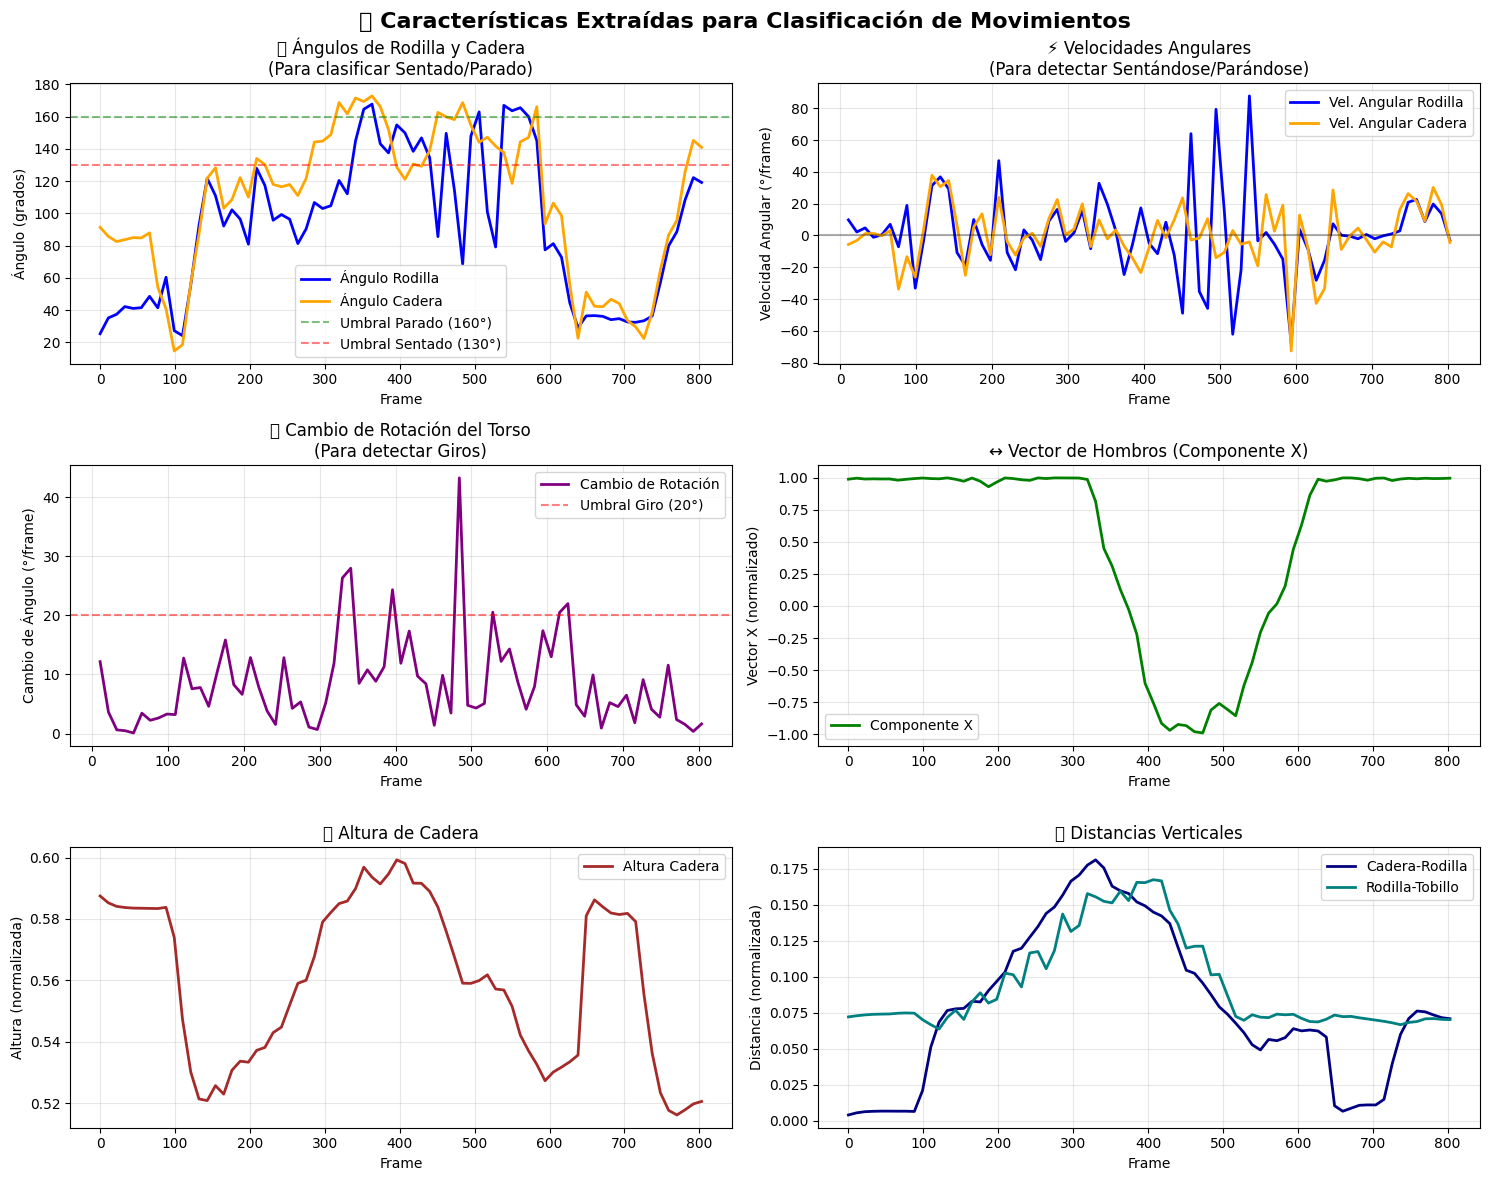

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Crear visualizaciones
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('🎯 Características Extraídas para Clasificación de Movimientos', fontsize=16, fontweight='bold')

# 1. Ángulos (Estado: Sentado/Parado)
axes[0, 0].plot(df_features['frame'], df_features['knee_angle'], label='Ángulo Rodilla', color='blue', linewidth=2)
axes[0, 0].plot(df_features['frame'], df_features['hip_angle'], label='Ángulo Cadera', color='orange', linewidth=2)
axes[0, 0].axhline(y=160, color='green', linestyle='--', alpha=0.5, label='Umbral Parado (160°)')
axes[0, 0].axhline(y=130, color='red', linestyle='--', alpha=0.5, label='Umbral Sentado (130°)')
axes[0, 0].set_xlabel('Frame')
axes[0, 0].set_ylabel('Ángulo (grados)')
axes[0, 0].set_title('📐 Ángulos de Rodilla y Cadera\n(Para clasificar Sentado/Parado)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Velocidades Angulares (Transición: Sentándose/Parándose)
axes[0, 1].plot(df_features['frame'], df_features['knee_angular_velocity'], label='Vel. Angular Rodilla', color='blue', linewidth=2)
axes[0, 1].plot(df_features['frame'], df_features['hip_angular_velocity'], label='Vel. Angular Cadera', color='orange', linewidth=2)
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Velocidad Angular (°/frame)')
axes[0, 1].set_title('⚡ Velocidades Angulares\n(Para detectar Sentándose/Parándose)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Cambio de rotación (Giro)
axes[1, 0].plot(df_features['frame'], df_features['rotation_angle_change'], label='Cambio de Rotación', color='purple', linewidth=2)
axes[1, 0].axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Umbral Giro (20°)')
axes[1, 0].set_xlabel('Frame')
axes[1, 0].set_ylabel('Cambio de Ángulo (°/frame)')
axes[1, 0].set_title('🔄 Cambio de Rotación del Torso\n(Para detectar Giros)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Vector de hombros (componente X)
axes[1, 1].plot(df_features['frame'], df_features['shoulder_vector_x'], label='Componente X', color='green', linewidth=2)
axes[1, 1].set_xlabel('Frame')
axes[1, 1].set_ylabel('Vector X (normalizado)')
axes[1, 1].set_title('↔️ Vector de Hombros (Componente X)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Altura de cadera
axes[2, 0].plot(df_features['frame'], df_features['hip_height'], label='Altura Cadera', color='brown', linewidth=2)
axes[2, 0].set_xlabel('Frame')
axes[2, 0].set_ylabel('Altura (normalizada)')
axes[2, 0].set_title('📏 Altura de Cadera')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Distancias verticales
axes[2, 1].plot(df_features['frame'], df_features['hip_knee_distance_y'], label='Cadera-Rodilla', color='navy', linewidth=2)
axes[2, 1].plot(df_features['frame'], df_features['knee_ankle_distance_y'], label='Rodilla-Tobillo', color='teal', linewidth=2)
axes[2, 1].set_xlabel('Frame')
axes[2, 1].set_ylabel('Distancia (normalizada)')
axes[2, 1].set_title('📊 Distancias Verticales')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('movement_features_visualization.png', dpi=150, bbox_inches='tight')
print("\n📊 Visualización guardada como: movement_features_visualization.png")
plt.show()

# Descargar visualización
files.download('movement_features_visualization.png')

## 🎯 Análisis de Correlaciones

In [ ]:
# Matriz de correlación
feature_columns = [
    'knee_angle', 'hip_angle',
    'knee_angular_velocity', 'hip_angular_velocity',
    'rotation_angle_change', 'hip_height',
    'hip_knee_distance_y', 'knee_ankle_distance_y'
]

correlation_matrix = df_features[feature_columns].corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlación')
plt.xticks(range(len(feature_columns)), feature_columns, rotation=45, ha='right')
plt.yticks(range(len(feature_columns)), feature_columns)
plt.title('🔍 Matriz de Correlación de Características', fontsize=14, fontweight='bold', pad=20)

# Añadir valores en cada celda
for i in range(len(feature_columns)):
    for j in range(len(feature_columns)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
print("\n📊 Matriz de correlación guardada como: correlation_matrix.png")
plt.show()

files.download('correlation_matrix.png')

## 📝 Resumen y Próximos Pasos

In [ ]:
print("="*60)
print("🎉 RESUMEN DE EXTRACCIÓN DE CARACTERÍSTICAS")
print("="*60)
print(f"\n✅ Total de frames procesados: {len(df_features)}")
print(f"✅ Total de características: {len(df_features.columns) - 1}")  # -1 por la columna 'frame'

print("\n📊 CARACTERÍSTICAS EXTRAÍDAS POR CATEGORÍA:")
print("\n1️⃣  ESTADO (Sentado/Parado):")
print("    • knee_angle: Ángulo de la rodilla")
print("    • hip_angle: Ángulo de la cadera")

print("\n2️⃣  TRANSICIÓN (Sentándose/Parándose):")
print("    • knee_angular_velocity: Velocidad angular de la rodilla")
print("    • hip_angular_velocity: Velocidad angular de la cadera")

print("\n3️⃣  GIRO:")
print("    • rotation_angle_change: Cambio de ángulo de rotación del torso")
print("    • shoulder_vector_x: Componente X del vector de hombros")
print("    • shoulder_vector_z: Componente Z del vector de hombros")

print("\n4️⃣  ADICIONALES:")
print("    • hip_height: Altura de la cadera")
print("    • hip_knee_distance_y: Distancia vertical cadera-rodilla")
print("    • knee_ankle_distance_y: Distancia vertical rodilla-tobillo")

print("\n" + "="*60)
print("🚀 PRÓXIMOS PASOS PARA ENTRENAR EL MODELO:")
print("="*60)

print("\n1. 🏷️  ETIQUETAR LOS DATOS:")
print("   • Añadir columnas con las etiquetas reales:")
print("     - 'estado': 'sentado' o 'parado'")
print("     - 'accion': 'sentandose', 'parandose', 'girando', 'ninguna'")

print("\n2. 🧹 PREPROCESAMIENTO:")
print("   • Manejar valores NaN (primeros frames sin velocidades)")
print("   • Normalizar/escalar características si es necesario")
print("   • Balancear clases si hay desbalance")

print("\n3. 🤖 ENTRENAR MODELOS:")
print("   • Para ESTADO: Random Forest o SVM con knee_angle + hip_angle")
print("   • Para TRANSICIÓN: Modelo temporal (LSTM/GRU) con velocidades angulares")
print("   • Para GIRO: Clasificador simple con rotation_angle_change")

print("\n4. ✅ VALIDACIÓN:")
print("   • División train/test (80/20)")
print("   • Validación cruzada")
print("   • Métricas: Accuracy, Precision, Recall, F1-Score")

print("\n5. 🎯 OPTIMIZACIÓN:")
print("   • Ajuste de hiperparámetros")
print("   • Feature engineering adicional si es necesario")
print("   • Ensemble de modelos")

print("\n" + "="*60)
print("💡 VENTAJAS DE ESTE ENFOQUE:")
print("="*60)
print("\n✨ Sin dependencia de umbrales manuales")
print("✨ Modelo aprende patrones complejos de los datos")
print("✨ Características físicamente interpretables")
print("✨ Fácil de extender con nuevas acciones")
print("✨ Robustez ante variaciones individuales")

print("\n" + "="*60)
print("📂 ARCHIVOS GENERADOS:")
print("="*60)
print("\n✅ movement_features.csv - Dataset principal")
print("✅ movement_features.json - Dataset en formato JSON")
print("✅ movement_features_visualization.png - Gráficos de características")
print("✅ correlation_matrix.png - Matriz de correlación")

print("\n" + "="*60)
print("🎓 ¡LISTO PARA ENTRENAR TU MODELO!")
print("="*60 + "\n")

## 🔬 Ejemplo de Clasificación Simple (Baseline)

🎯 EJEMPLO DE CLASIFICACIÓN BASADA EN REGLAS SIMPLES

Este es un ejemplo básico para demostrar el concepto.
Para un modelo robusto, necesitas etiquetar manualmente tus datos.

📊 Distribución de etiquetas (sintéticas):
estado_label
sentado    42
parado      2
Name: count, dtype: int64

📈 RESULTADOS DEL MODELO BASELINE:

Reporte de Clasificación:
              precision    recall  f1-score   support

      parado       0.00      0.00      0.00         2
     sentado       0.78      1.00      0.88         7

    accuracy                           0.78         9
   macro avg       0.39      0.50      0.44         9
weighted avg       0.60      0.78      0.68         9



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


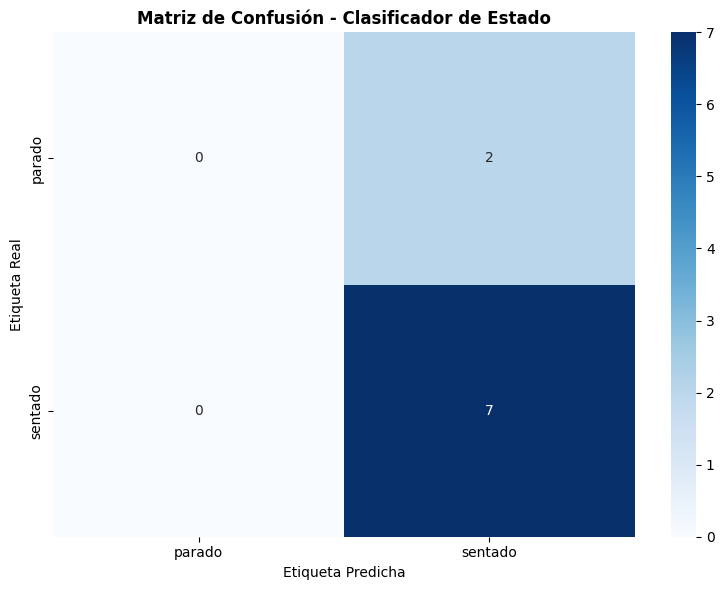


🎯 Importancia de Características:
      feature  importance
0  knee_angle         0.0
1   hip_angle         0.0

⚠️  IMPORTANTE:
Este es solo un ejemplo con etiquetas sintéticas.
Para un modelo real, necesitas:
  1. Etiquetar manualmente los frames
  2. Usar más datos de entrenamiento
  3. Probar diferentes arquitecturas de modelos
  4. Validar con datos de diferentes personas/condiciones


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("🎯 EJEMPLO DE CLASIFICACIÓN BASADA EN REGLAS SIMPLES")
print("="*60)
print("\nEste es un ejemplo básico para demostrar el concepto.")
print("Para un modelo robusto, necesitas etiquetar manualmente tus datos.\n")

# Crear etiquetas sintéticas basadas en las características
# NOTA: Estas son etiquetas de ejemplo. En producción, debes etiquetarlas manualmente.

def label_state(row):
    """Etiqueta el estado basado en ángulos (ejemplo simplificado)"""
    if pd.isna(row['knee_angle']) or pd.isna(row['hip_angle']):
        return None

    # Si ambos ángulos son grandes -> Parado
    if row['knee_angle'] > 160 and row['hip_angle'] > 160:
        return 'parado'
    # Si ambos ángulos son pequeños -> Sentado
    elif row['knee_angle'] < 130 and row['hip_angle'] < 130:
        return 'sentado'
    # En transición
    else:
        return 'transicion'

# Aplicar etiquetado
df_features['estado_label'] = df_features.apply(label_state, axis=1)

# Filtrar solo estados claros (parado/sentado) para el ejemplo
df_labeled = df_features[df_features['estado_label'].isin(['parado', 'sentado'])].copy()

print(f"📊 Distribución de etiquetas (sintéticas):")
print(df_labeled['estado_label'].value_counts())
print()

if len(df_labeled) > 10:  # Solo si tenemos suficientes datos
    # Preparar datos para entrenamiento
    X = df_labeled[['knee_angle', 'hip_angle']].values
    y = df_labeled['estado_label'].values

    # División train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar modelo simple
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predicciones
    y_pred = clf.predict(X_test)

    # Resultados
    print("📈 RESULTADOS DEL MODELO BASELINE:")
    print("="*60)
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['parado', 'sentado'],
                yticklabels=['parado', 'sentado'])
    plt.title('Matriz de Confusión - Clasificador de Estado', fontweight='bold')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Importancia de características
    feature_importance = pd.DataFrame({
        'feature': ['knee_angle', 'hip_angle'],
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n🎯 Importancia de Características:")
    print(feature_importance)

    print("\n" + "="*60)
    print("⚠️  IMPORTANTE:")
    print("="*60)
    print("Este es solo un ejemplo con etiquetas sintéticas.")
    print("Para un modelo real, necesitas:")
    print("  1. Etiquetar manualmente los frames")
    print("  2. Usar más datos de entrenamiento")
    print("  3. Probar diferentes arquitecturas de modelos")
    print("  4. Validar con datos de diferentes personas/condiciones")

else:
    print("⚠️  No hay suficientes datos etiquetados para el ejemplo.")
    print("Procesa un video más largo o etiqueta manualmente los datos.")